# Validation tests for the model in [nswe_wbmuscl2_handu.ipynb](nswe_wbmuscl2_handu.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import nswe_wbmuscl2 as wb2

# Lake at rest

From Berthon and Marche (2008), section 6.3.

The topography is defined by

$$ d(x,y)  = \begin{cases}
0.2 - 0.05(x-10)^2 & \text{ if } 8m < x < 12m \\
0 & \text{ else}
\end{cases}$$

and the water level is set to $0.1m$

In [3]:
nt = 20
nx = 100
cfl = 1.0

In [4]:
x = np.linspace(0,25,nx)
dx = np.diff(x)[0]
d0 = np.where((x>8)*(x<12), 0.2-0.05*(x-10.)**2, 0.0)
h0 = np.where(0.1-d0>=0, 0.1-d0, 0.0)
u0 = np.zeros_like(h0)

* Initial condition

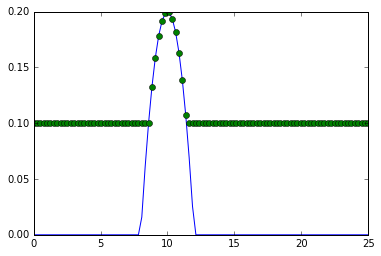

In [5]:
plt.plot(x,d0)
plt.plot(x,h0+d0,'o')

In [6]:
t,h,u = wb2.sim_rk4(h0, u0, d0, nt, nx, cfl, dx, wb2.bcs_open, hmin=0.0)

nswe_wbmuscl2.py:325: RuntimeWarning: invalid value encountered in divide
  u2 = np.where( h2>hmin, (h[n,:]*u[n,:]+0.5*k1[1,:]*dt)/h2, 0.0)
nswe_wbmuscl2.py:329: RuntimeWarning: invalid value encountered in divide
  u3 = np.where(h3>hmin, (h[n,:]*u[n,:]+0.5*k2[1,:]*dt)/h3, 0.0)
nswe_wbmuscl2.py:333: RuntimeWarning: invalid value encountered in divide
  u4 = np.where(h4>hmin, (h[n,:]*u[n,:]+k3[1,:]*dt)/h4, 0.0)
nswe_wbmuscl2.py:338: RuntimeWarning: invalid value encountered in divide
  u[n+1,:] = np.where(h[n+1,:]>hmin, hu/h[n+1,:], 0.0)


* Difference between computed solution and initial condition 

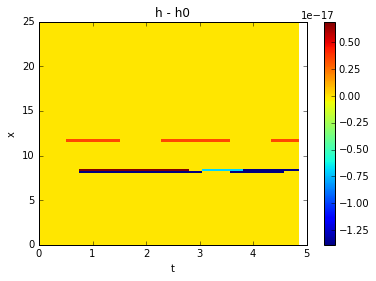

In [7]:
tax, xax = np.meshgrid(t,x)
plt.pcolormesh(tax.T,xax.T,np.array([h[i,2:-2]-h[0,2:-2] for i in range(h.shape[0])]))
plt.colorbar()
plt.title('h - h0')
plt.xlabel('t')
plt.ylabel('x')

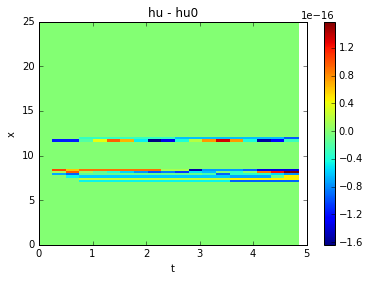

In [8]:
plt.pcolormesh(tax.T,xax.T,np.array([u[i,2:-2]-u[0,2:-2] for i in range(h.shape[0])]))
plt.colorbar()
plt.title('hu - hu0')
plt.xlabel('t')
plt.ylabel('x')

* Animation of the simulation


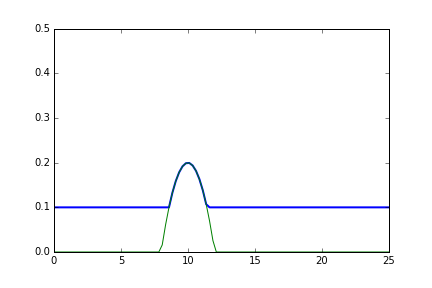
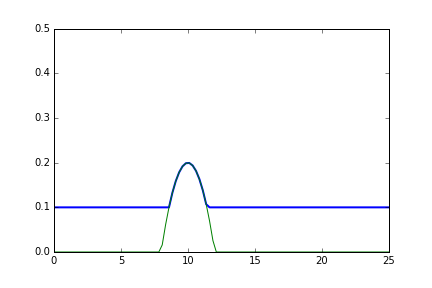
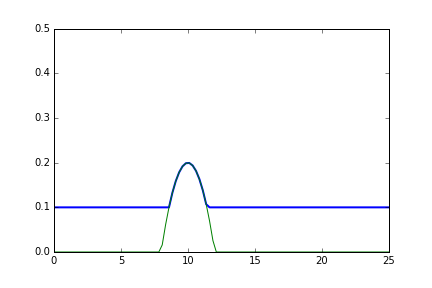
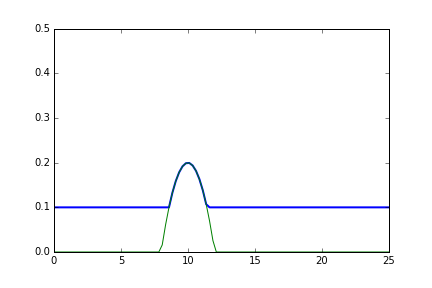
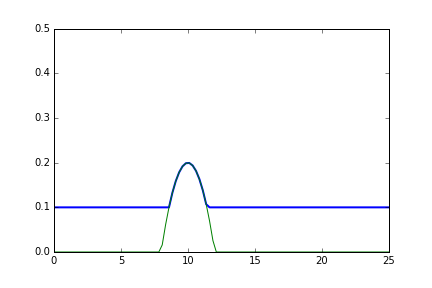
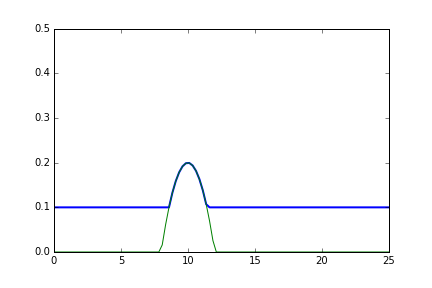
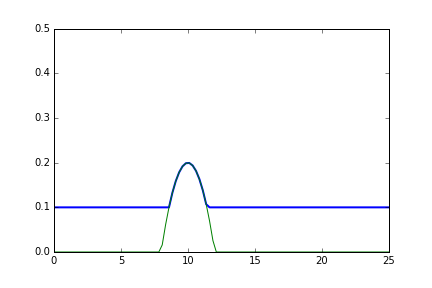
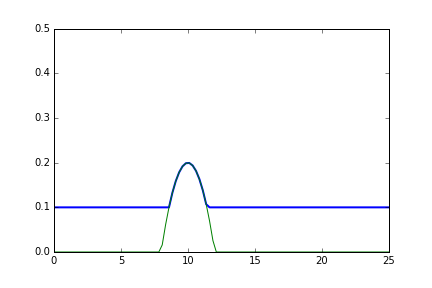
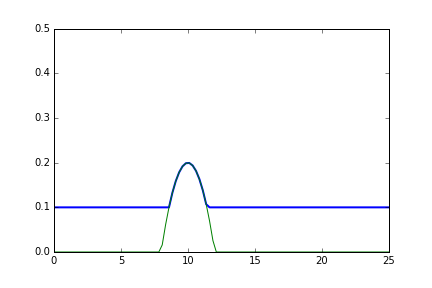
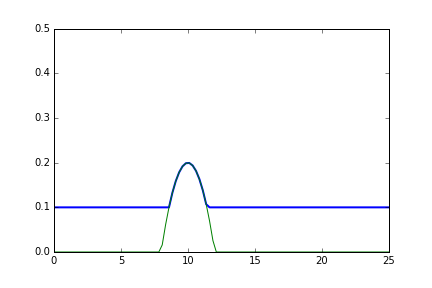
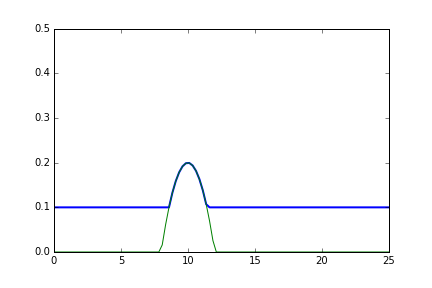
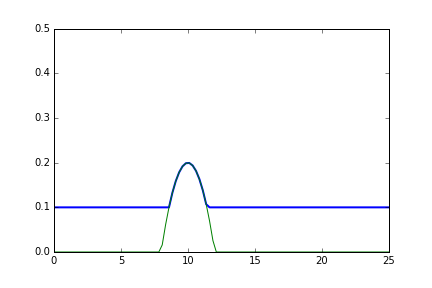
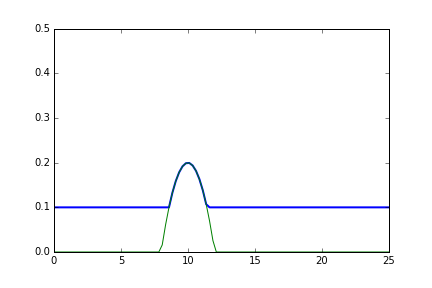
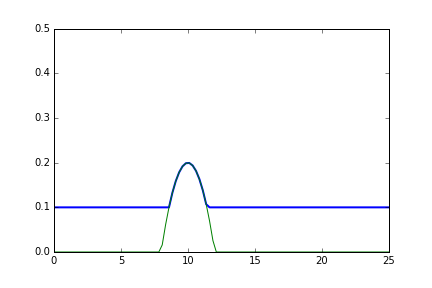
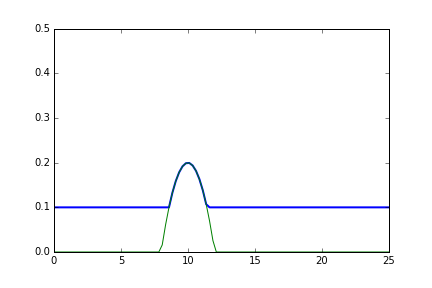
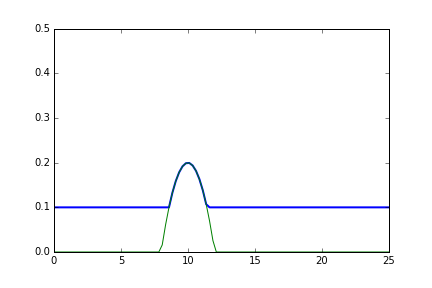
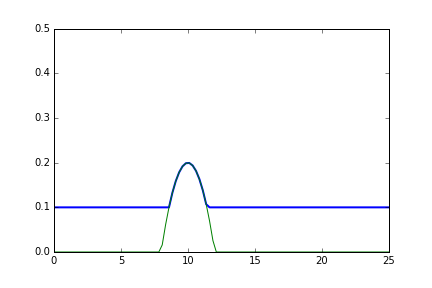
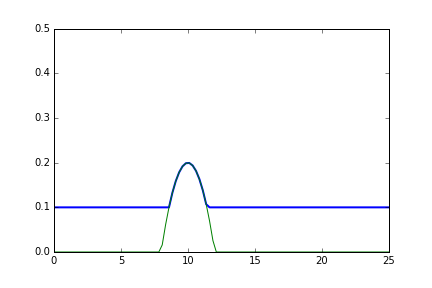
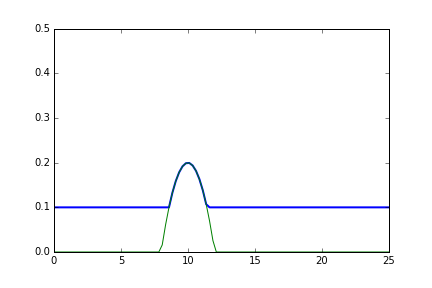

In [9]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(0, 25), ylim=(0.0,0.5))
line, = ax.plot([], [], lw=2)
lineb, = ax.plot(x,d0)

def animate(i):
    line.set_data(x, h[i,2:-2]+d0)
    return line,

animation.FuncAnimation(fig, animate, frames=nt-1, interval=45)

# Sinusoidal wave propagation in shallow water

The boundary condition is defined as follows:

Given $h_b(t)$ the water height at the boundary, the value to use in the first ghost cell is $$h_L = h_b(t+\Delta t)$$ and for $hu$ is $$(hu)_L = c_0 (h_L-h_0)$$ with $h_0$ the mean water level.

In [10]:


def bcs_inwave_open(d,h0,u0,href,hwave,t,dt):
    """ 
        incident wave height at the left boundary
        open at the right boundary
    """
    hl  = hwave(t+dt)
    hul = np.sqrt(9.81*href)*(hl-href)
    ul = hul/hl
    hr = h0[2]
    ur = u0[2]
    
    Rlplus = ul + 2.*np.sqrt(9.81*hl)
    Rrminus = ur - 2.*np.sqrt(9.81*hr)
    
    ua = 0.5*(Rlplus + Rrminus)
    ha = 1./(16.*9.81)*(Rlplus-Rrminus)**2
    
    db = 1.*d
    hb = 1.*h0
    ub = 1.*u0
    
    db[0] = db[2]
    db[1] = db[2]
    hb[0] = ha
    hb[1] = ha
    ub[0] = ua
    ub[1] = ua
    
    db[-1] = db[-4]
    db[-2] = db[-3]
    hb[-1] = hb[-4]
    hb[-2] = hb[-3]
    ub[-1] = ub[-4]    
    ub[-2] = ub[-3]    
    return db,hb,ub

In [11]:
nt = 100
nx = 50
cfl = 1.0

(0, 11)

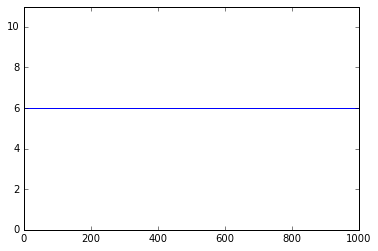

In [12]:
x = np.linspace(0,1000,nx)
H0 = 6.
T = 0.5
a = 2.0

d0 =  np.where((x>=200)*(x<=300),4.0,0.0)*0.0
h0 = H0-d0
h0 = np.where(h0<=0,1e-5,h0)
hu0 = np.zeros_like(x)
plt.plot(x,h0+d0)
plt.plot(x,d0)
plt.ylim(0,11)

In [13]:
def sinwave(t):
    return np.sin(t/T*2.*np.pi)*a+H0

In [14]:
t, h,hu = wb2.sim_rk4(h0, hu0, d0, nt, nx, cfl, dx, bcs=bcs_inwave_open, bcargs=[H0,sinwave], hmin=1e-5)


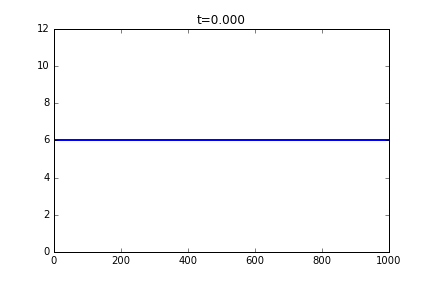
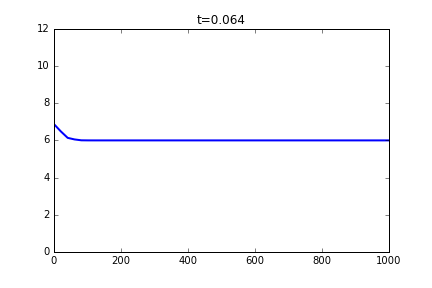
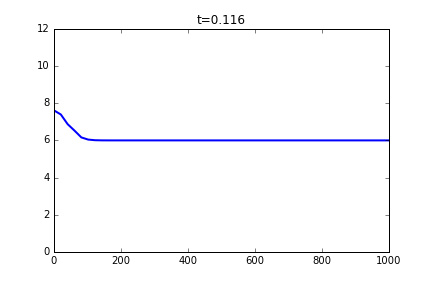
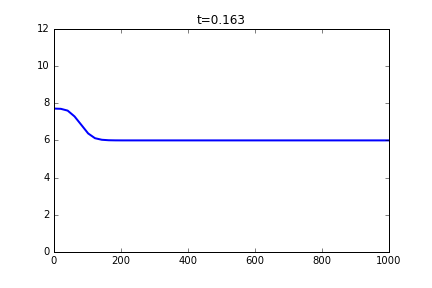
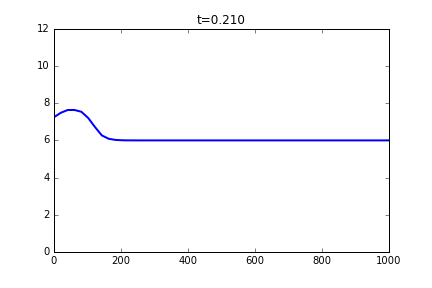
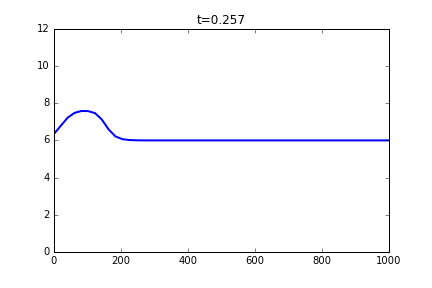
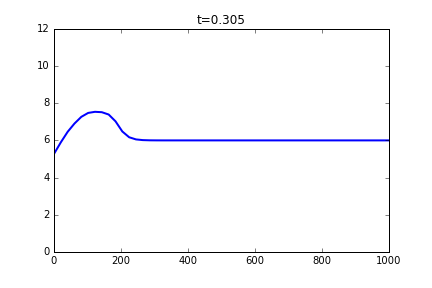
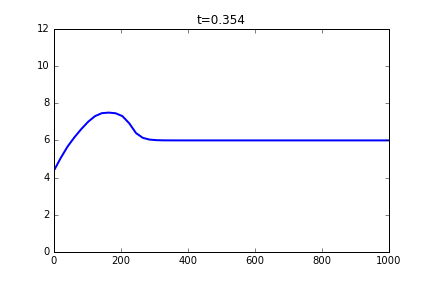
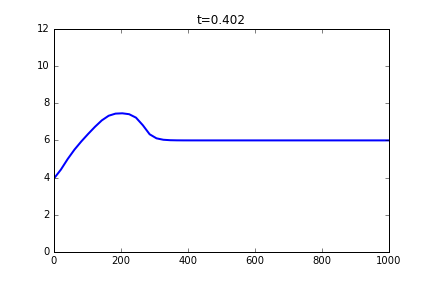
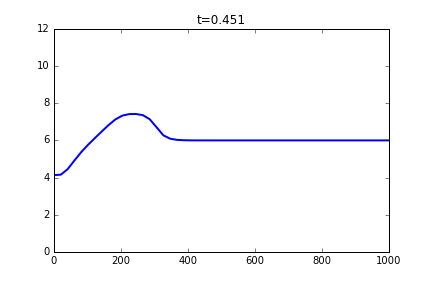
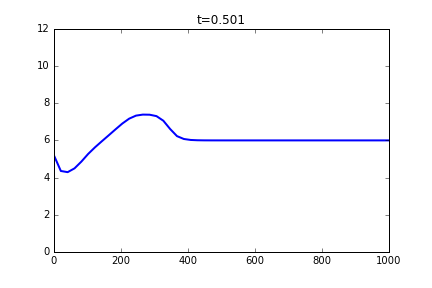
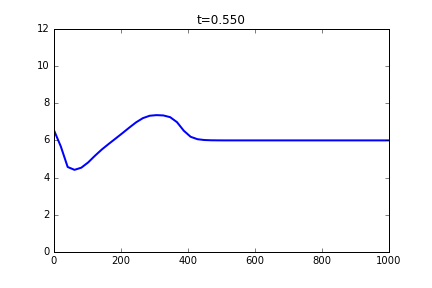
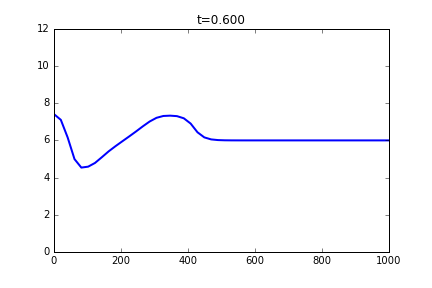
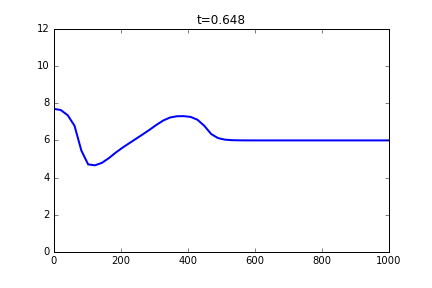
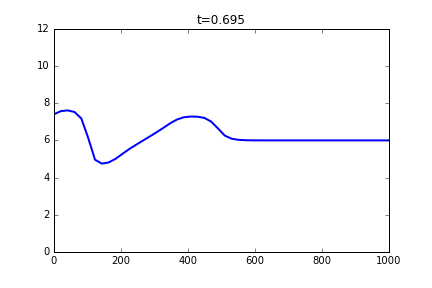
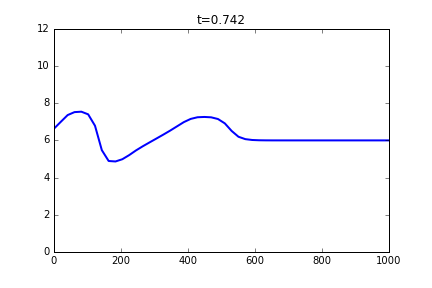
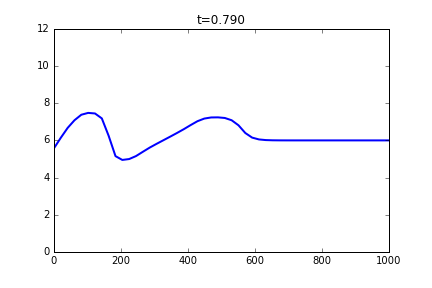
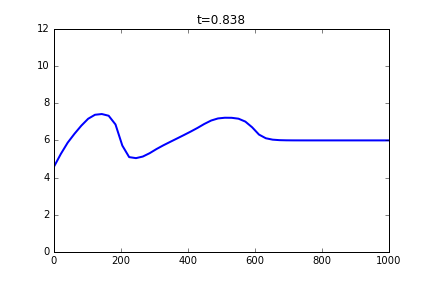
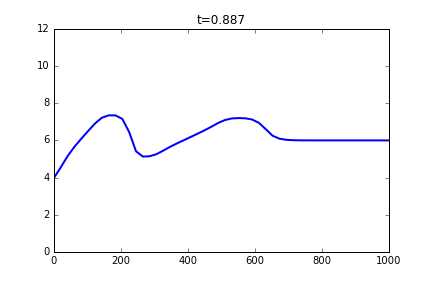
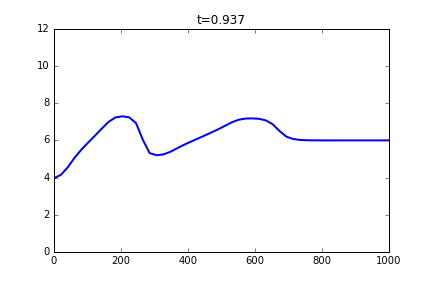
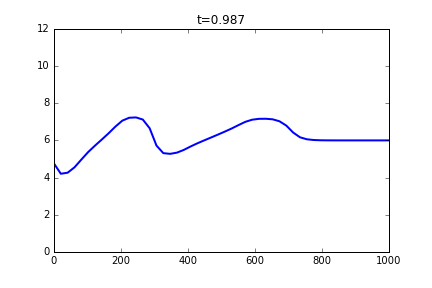
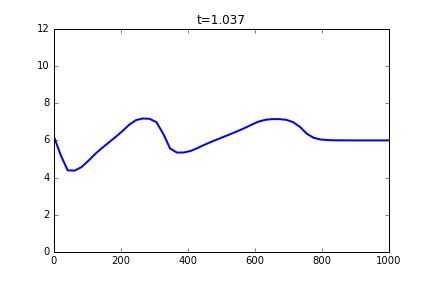
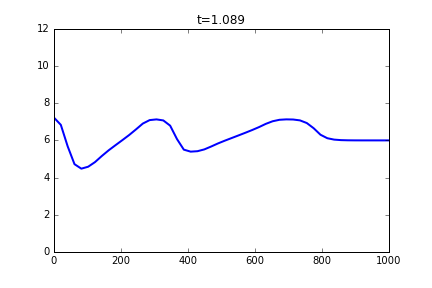
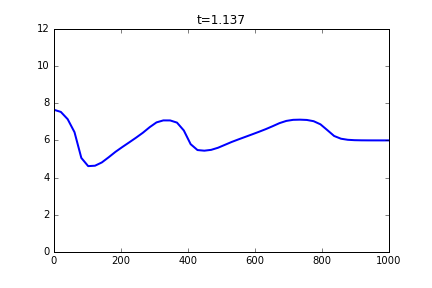
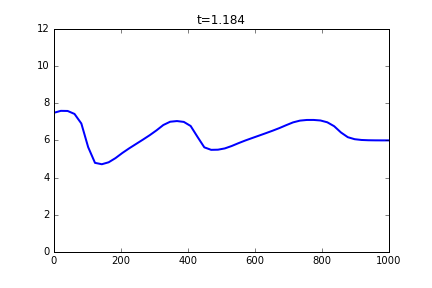
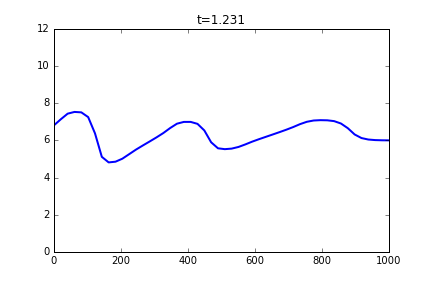
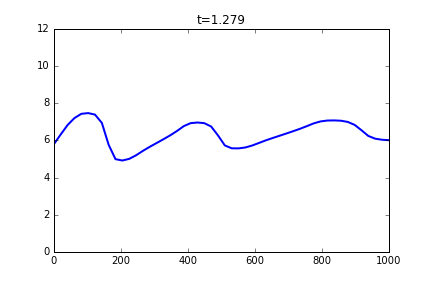
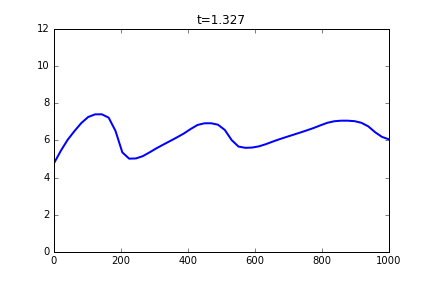
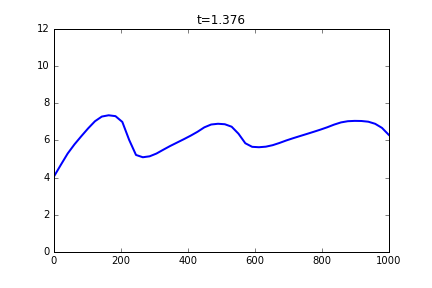
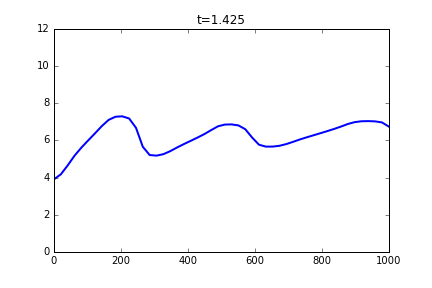
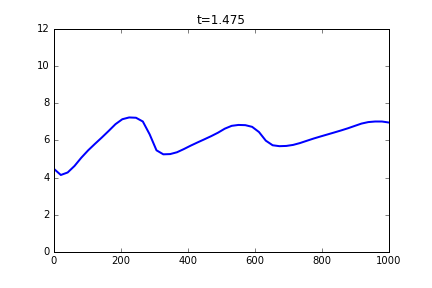
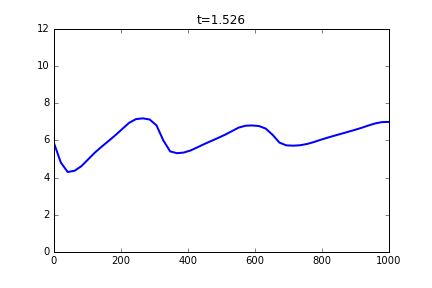
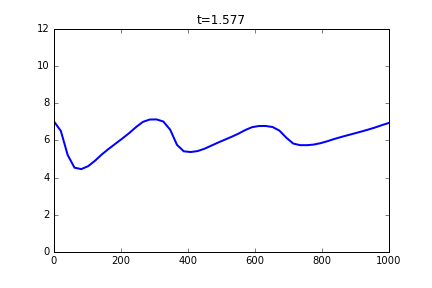
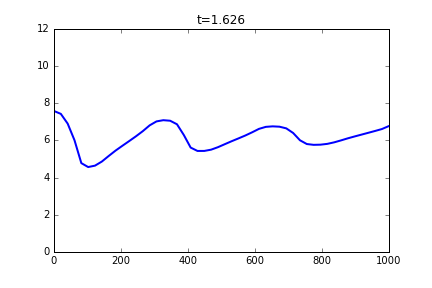
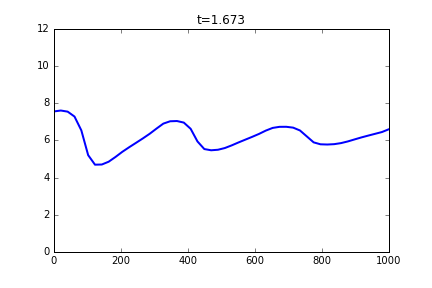
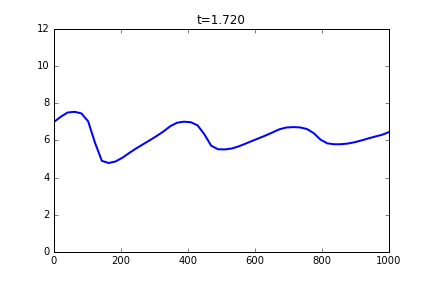
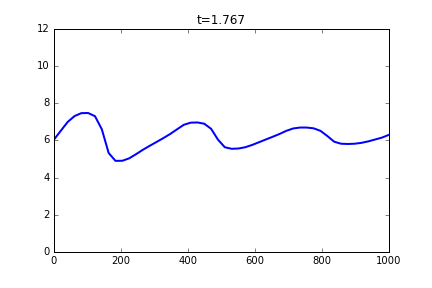
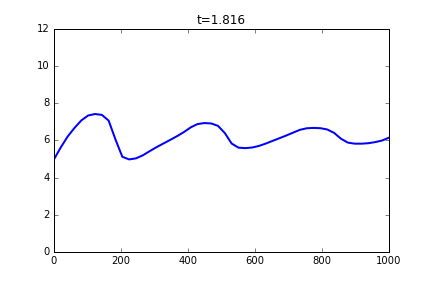
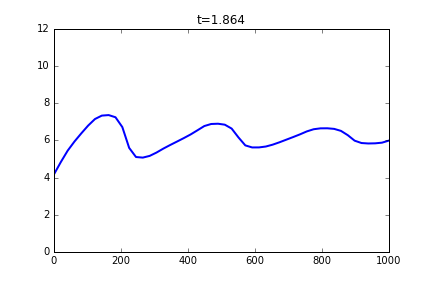
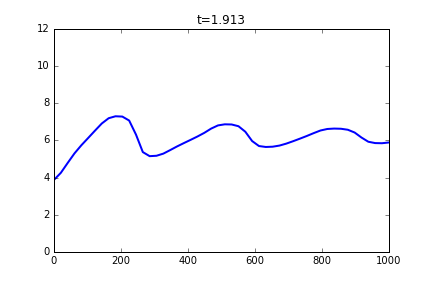
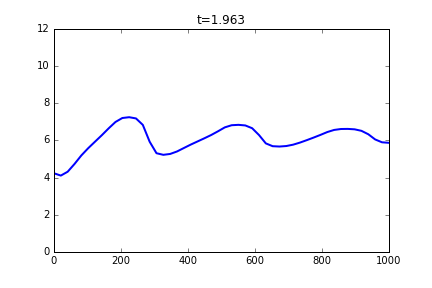
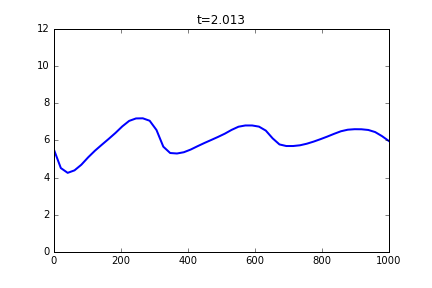
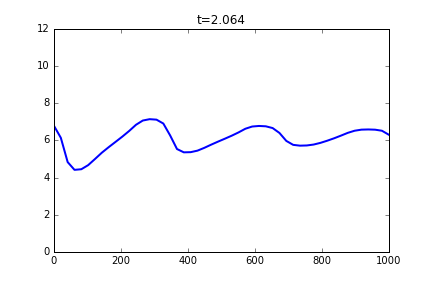
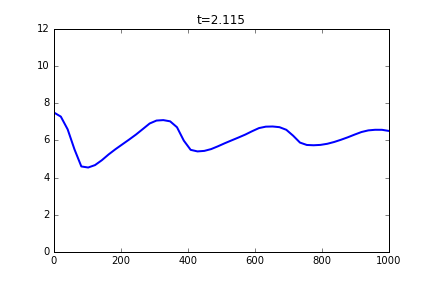
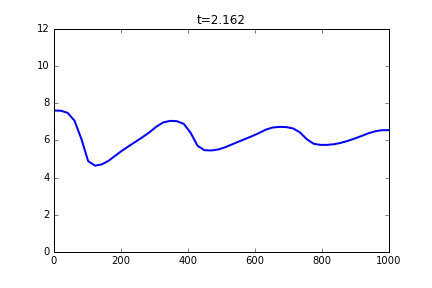
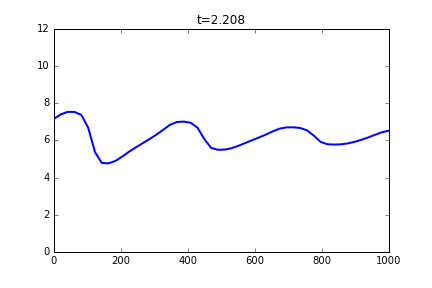
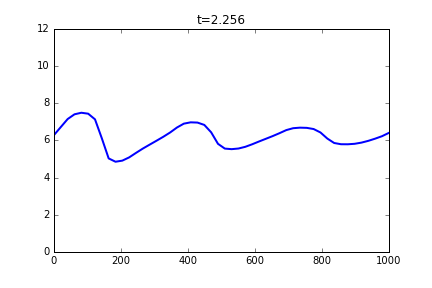
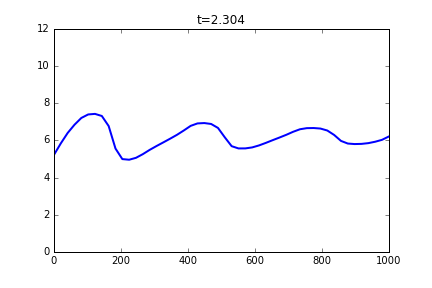
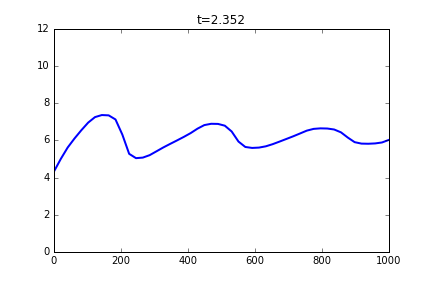
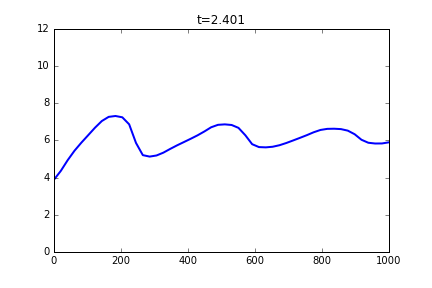

In [15]:
fig = plt.figure()
ax = plt.axes(xlim=(0, x.max()), ylim=(0.0,12.))
line, = ax.plot([], [], lw=2)
lineb, = ax.plot(x,d0)
tt = ax.set_title('t')
def animate(i):
    i = min(nt,i*2)
    line.set_data(x, h[i,2:-2]+d0)
    tt.set_text('t=%.3f'%t[i])
    return line,

animation.FuncAnimation(fig, animate, frames=nt/2, interval=100)

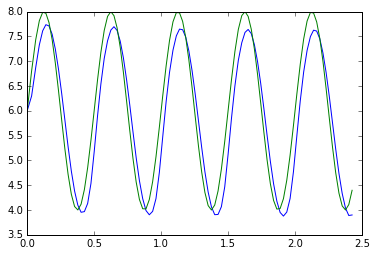

In [16]:
plt.plot(t,h[:,2])
plt.plot(t,sinwave(t))

# Same, but with slope

(0, 11)

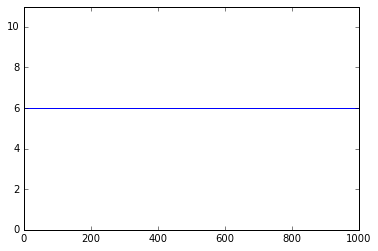

In [17]:
x = np.linspace(0,1000,nx)
H0 = 6.
T = 0.5
a = 2.0

d0 =  np.where((x>=200)*(x<=300),4.0,0.0)*0.0
h0 = H0-d0
h0 = np.where(h0<=0,1e-5,h0)
hu0 = np.zeros_like(x)
plt.plot(x,h0+d0)
plt.plot(x,d0)
plt.ylim(0,11)

# Subcritical flow over a bump

Section 6.2 in the paper of Berthon an Marche (2008)

Given $q_b(t)$ the water flow at the boundary, the value to use in the first ghost cell is $$hu_L = q_b(t+\Delta t)$$ and the water height is $$h_L = h_0 + \frac{q_L}{c_0}$$


In [18]:
%%writefile nswe_wbmuscl2.py -a

def bcs_inflow(d,h0,u0,hin,qin,t,dt):
    """ 
        incident wave height at the left boundary
        open at the right boundary
    """
    hl  = hin
    hul = qin
    ul = hul/hl
    hr = h0[2]
    ur = u0[2]
    
    Rlplus = ul + 2.*np.sqrt(9.81*hl)
    Rrminus = ur - 2.*np.sqrt(9.81*hr)
    
    ua = 0.5*(Rlplus + Rrminus)
    ha = 1./(16.*9.81)*(Rlplus-Rrminus)**2
    
    db = 1.*d
    hb = 1.*h0
    ub = 1.*u0
    db[0] = db[2]
    db[1] = db[2]
    hb[0] = hl
    hb[1] = hl
    ub[0] = ul
    ub[1] = ul
    
    
    hr = hin
    ur = qin/hin
    hl = h0[-3]
    ul = u0[-3]

    Rlplus = ul + 2.*np.sqrt(9.81*hl)
    Rrminus = ur - 2.*np.sqrt(9.81*hr)

    ua = 0.5*(Rlplus + Rrminus)
    ha = 1./(16.*9.81)*(Rlplus-Rrminus)**2
    
    db[-1] = db[-4]
    db[-2] = db[-4]
    hb[-1] = hr
    hb[-2] = hr
    ub[-1] = ur
    ub[-2] = ur
    
    return db,hb,ub

Appending to nswe_wbmuscl2.py


(0, 2.1)

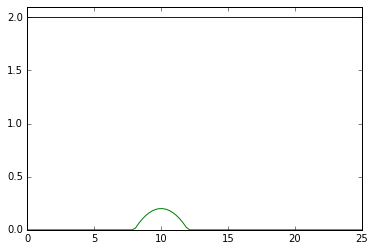

In [19]:
nt = 300
nx = 100
H0 = 2.
q0 = 4.42
x = np.linspace(0,25,nx)
d0 = np.where((x<=12.)*(x>=8), 0.2-0.05*(x-10.)**2,0.0)
h0 = H0-d0
u0 = np.ones_like(x)*4.42
u0 = u0/h0
plt.plot(x,h0+d0)
plt.plot(x,d0)
plt.ylim(0,2.1)

In [20]:
reload(wb2)

<module 'nswe_wbmuscl2' from 'nswe_wbmuscl2.py'>

In [22]:
tw, hw,uw = wb2.sim_rk4(h0, u0, d0, nt, nx, cfl, dx, bcs=wb2.bcs_inflow, bcargs=[H0,q0])

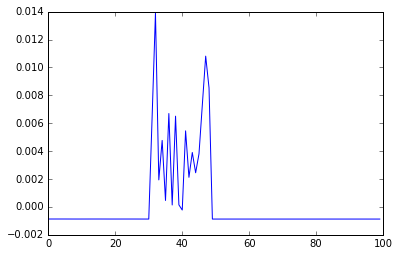

In [23]:
plt.plot(hw[-1,2:-2]*uw[-1,2:-2]-q0)


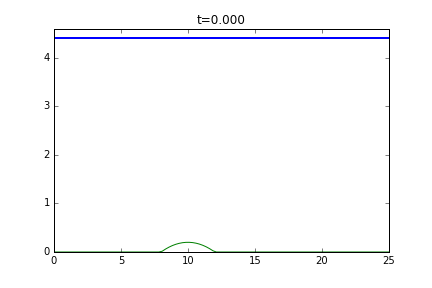
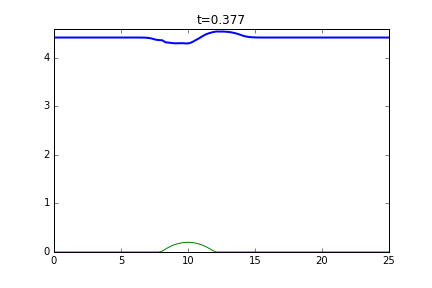
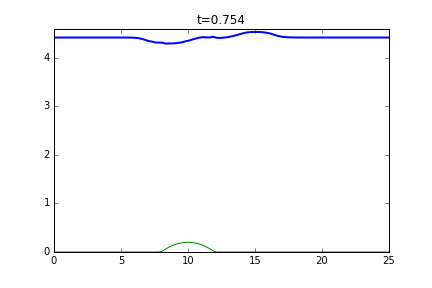
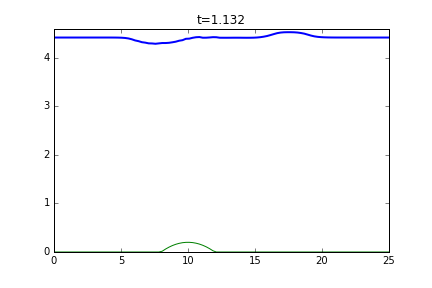
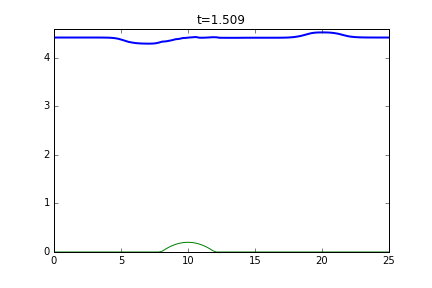
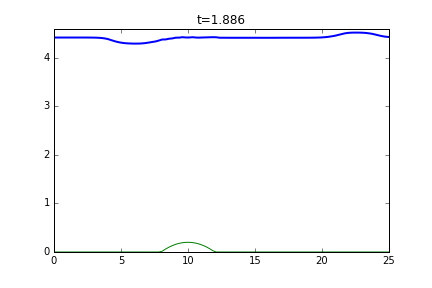
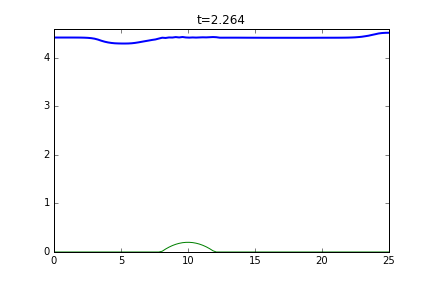
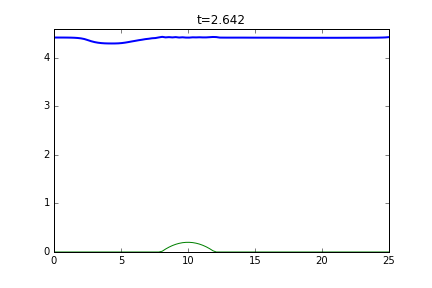
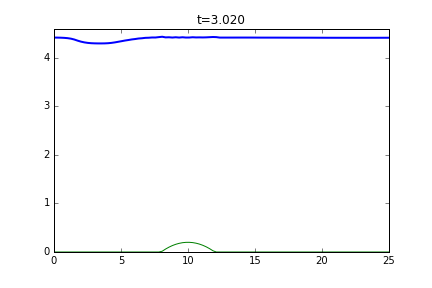
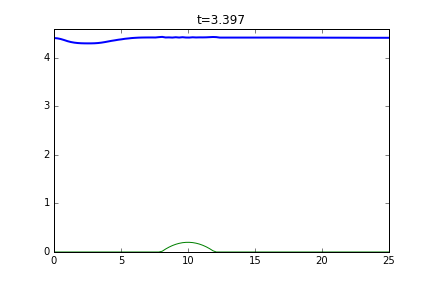
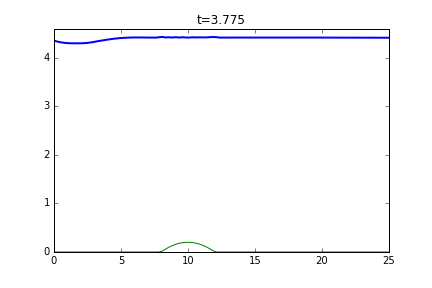
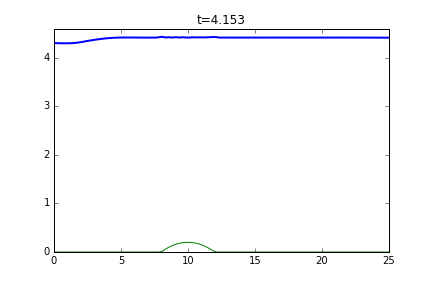
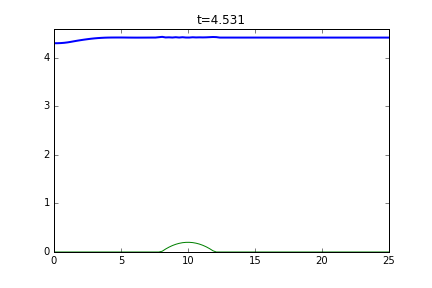
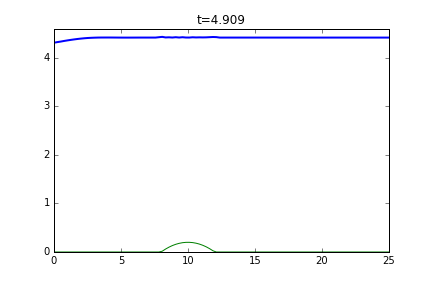
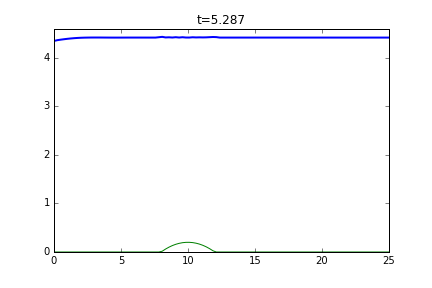
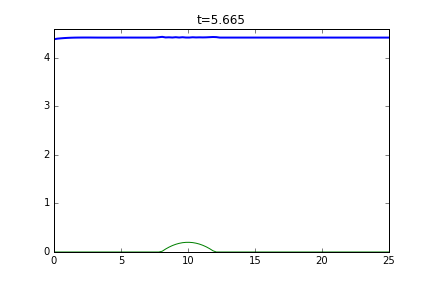
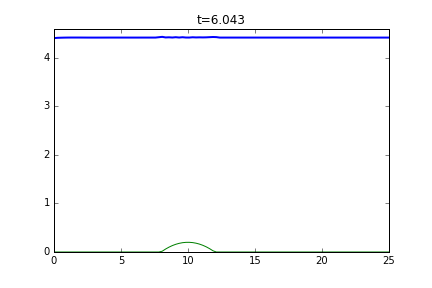
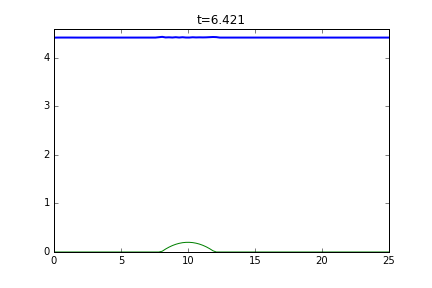
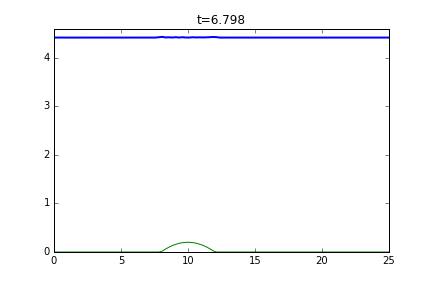
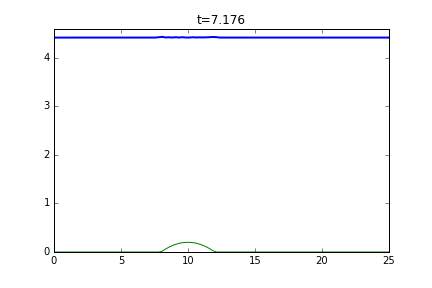
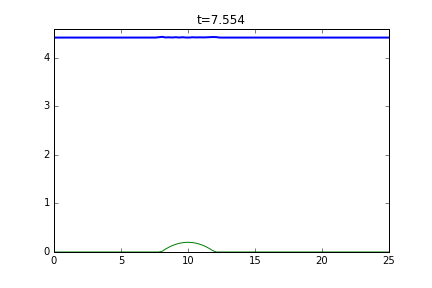
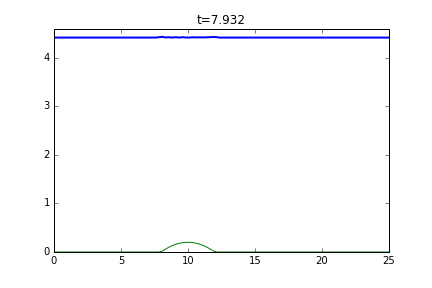
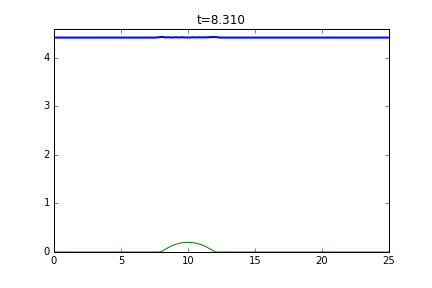
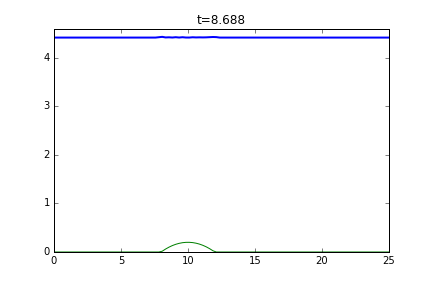
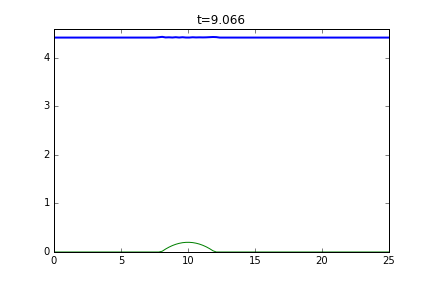
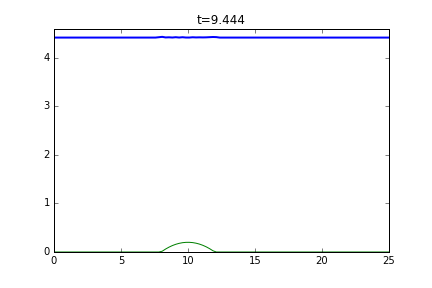
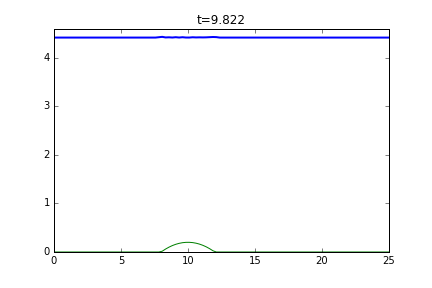
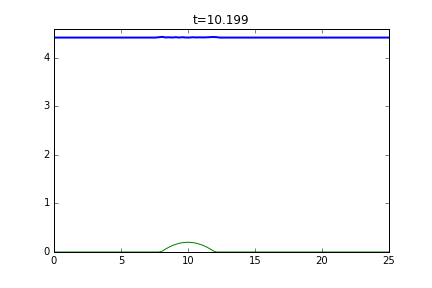
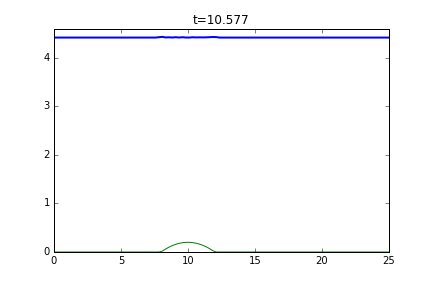

In [24]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 25), ylim=(0.0,4.6))
line, = ax.plot([], [], lw=2)
lineb, = ax.plot(x,d0)
timetext = ax.set_title('t=')
def animate(i):
    i = min(nt*4-1,i*10)
    line.set_data(x, hw[i,2:-2]*uw[i,2:-2])
    timetext.set_text('t=%.3f'%tw[i])
    return line,

animation.FuncAnimation(fig, animate, frames=(nt-1)/10, interval=45)

# Comparison with analytical solution

In [25]:
def b(x):
    d0 = np.where((x>8)*(x<12), 0.2-0.05*(x-10.)**2, 0.0)
    return d0
def tosolve(h,x,q,H0):
    eq = h + b(x) + q**2/(2.*9.81*h**2) - (H0+b(0)+q**2/(2.*9.81*H0**2))
    return eq

In [26]:
from scipy.optimize import fsolve

In [27]:
ha = np.array([fsolve(tosolve,H0,args=(x[i],q0,H0)) for i in range(x.shape[0])])
ua = hw[-1,2]*uw[-1,2]/ha

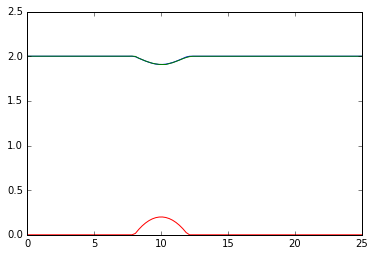

In [28]:
plt.plot(x,(ha[:,0]+d0), label='analytical');
plt.plot(x,hw[-1,2:-2]+d0, label='numerical')
plt.plot(x,d0)